In [1]:
#train01: try to replicate the same condition of UNet0's unet1.ipynb
#That is, dice loss with batch calculation, smooth =1
# import system libs
import os
from glob import glob

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from monai.losses import DiceLoss
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# import cv2
# import pandas as pd
# import numpy as np
import sys
sys.path.append('../model')
sys.path.append('../Unet0')
from unet import UNet
from utils import  create_dataloader, dice_coef, iou_coef
from torch.utils.tensorboard import SummaryWriter
# import data handling tools
import cv2
import numpy as np
import pandas as pd
# import seaborn as sns
# %matplotlib inline
# from skimage.color import rgb2gray
# from skimage.morphology import label
# from skimage.transform import resize
# from skimage.io import imread, imshow, concatenate_images
# sns.set_style('darkgrid')

%reload_ext autoreload
%autoreload 2

/home/vscode/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
def create_df(data_dir):
    images_paths = []
    masks_paths = sorted(glob(f'{data_dir}/*/*_mask*'))

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [3]:
data_dir = '/workspaces/data/kaggle_3m'

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)

In [4]:
len(train_df), len(valid_df), len(test_df)

(3143, 393, 393)

In [5]:
# %load_ext autoreload
# %autoreload 2
#from utils import create_dataloader
BATCH_SIZE = 8
train_loader = create_dataloader(train_df, batch_size=BATCH_SIZE, augment=True, num_workers=16)
valid_loader = create_dataloader(valid_df, batch_size=BATCH_SIZE, augment=False, num_workers=16)
test_loader = create_dataloader(test_df, batch_size=BATCH_SIZE, augment=False, num_workers=16)


/home/vscode/.local/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


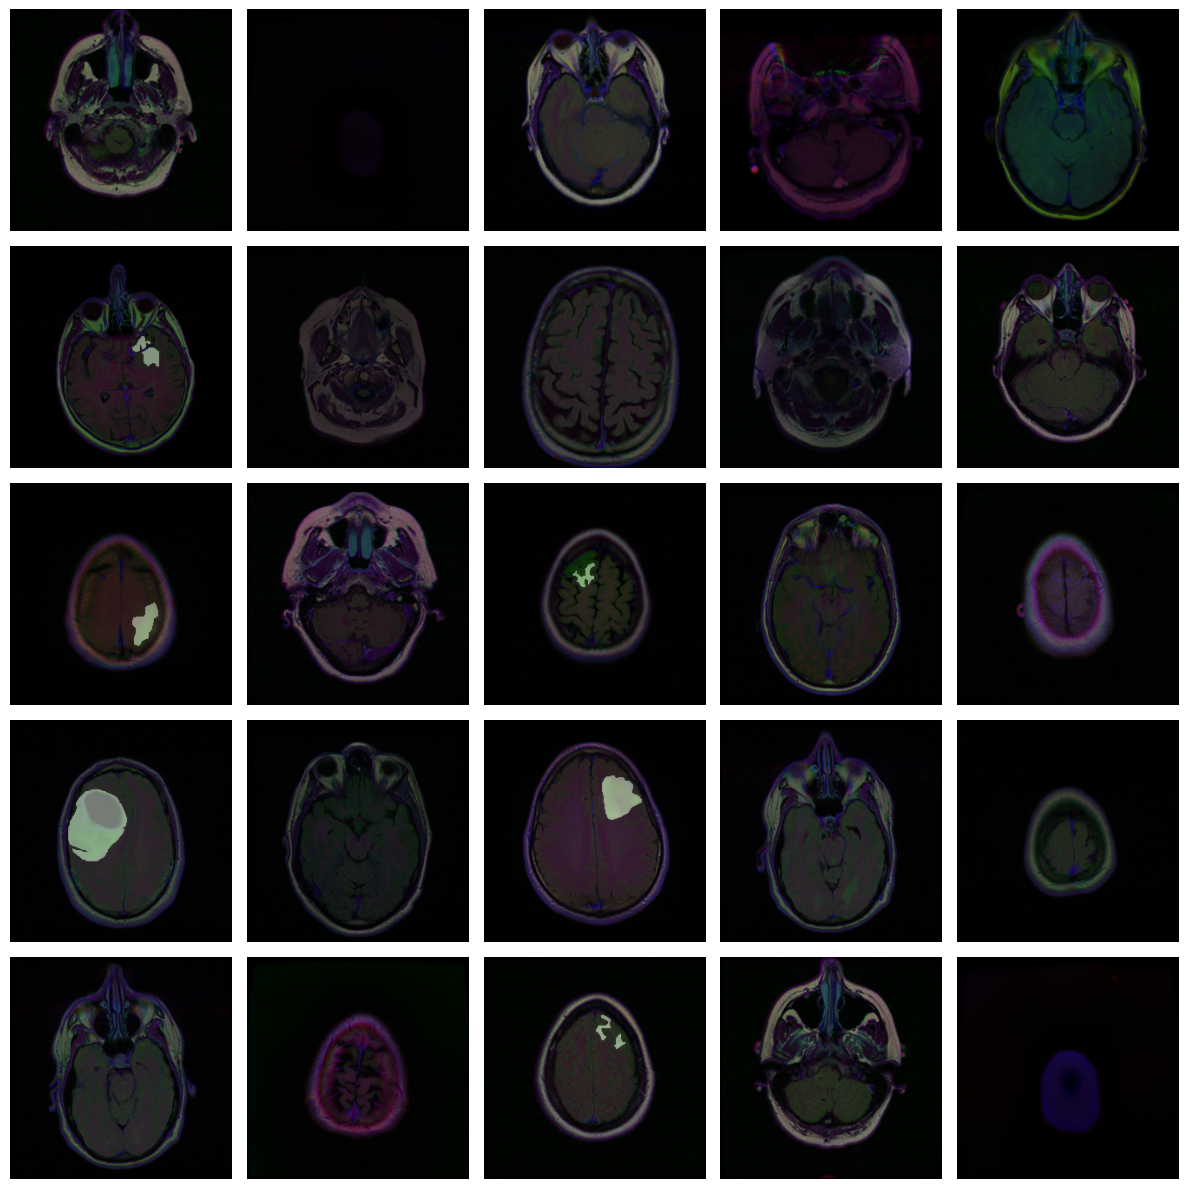

In [6]:
from utils import show_images
show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = UNet(in_channels=3, out_channels=1).to(device)
model = UNet(n_channels=3, n_classes=1).to(device) #returns logits, not probabilities
optimizer = optim.Adamax(model.parameters(), lr=0.001)
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True, batch=True, smooth_nr=1.0, smooth_dr=1.0)
criterion = dice_loss  # al

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_dice = 0
    total_iou = 0

    for images, masks in tqdm(dataloader, desc='Training'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)#round2: should be sigmoid activation
        # outputs = torch.sigmoid(outputs)  ## Not needed
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_coef(masks,torch.sigmoid(outputs),smooth=1).item()
        total_iou += iou_coef(masks, torch.sigmoid(outputs),smooth=1).item()

    n = len(dataloader)
    return total_loss / n, total_dice / n, total_iou / n



def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_dice = 0
    total_iou = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc='Validating'):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion( outputs, masks)
            total_loss += loss.item()
            total_dice += dice_coef(masks, torch.sigmoid(outputs),smooth=1).item()
            total_iou += iou_coef(masks, torch.sigmoid(outputs),smooth=1).item()

    n = len(dataloader)
    return total_loss / n, total_dice / n, total_iou / n


In [8]:
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 3, 256, 256))

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [8, 1, 256, 256]          --
├─DoubleConv: 1-1                             [8, 64, 256, 256]         --
│    └─Sequential: 2-1                        [8, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                       [8, 64, 256, 256]         1,728
│    │    └─BatchNorm2d: 3-2                  [8, 64, 256, 256]         128
│    │    └─ReLU: 3-3                         [8, 64, 256, 256]         --
│    │    └─Conv2d: 3-4                       [8, 64, 256, 256]         36,864
│    │    └─BatchNorm2d: 3-5                  [8, 64, 256, 256]         128
│    │    └─ReLU: 3-6                         [8, 64, 256, 256]         --
├─Down: 1-2                                   [8, 128, 128, 128]        --
│    └─Sequential: 2-2                        [8, 128, 128, 128]        --
│    │    └─MaxPool2d: 3-7                    [8, 64, 128, 128]         --
│    │    └

In [9]:
# import os
import datetime

epochs = 120
best_val_loss = float('inf')
save_path = 'LG2-01.pth'

log_dir = os.path.join("/workspaces/data/MegaGen/UNet", 
                       "unet_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir=log_dir)
history = {
    'train_loss': [],
    'train_dice': [],
    'train_iou': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
}



In [10]:
print ("device:",next(model.parameters()).device)
for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")

    train_loss, train_dice, train_iou = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_dice, val_iou = validate(model, valid_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} → {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)

    # Log to TensorBoard
    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Val", val_loss, epoch)
    writer.add_scalar("Dice/Train", train_dice, epoch)
    writer.add_scalar("Dice/Val", val_dice, epoch)
    writer.add_scalar("IoU/Train", train_iou, epoch)
    writer.add_scalar("IoU/Val", val_iou, epoch)

    # Save to history
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['train_iou'].append(train_iou)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)


device: cuda:0

Epoch 1/120


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Validating: 100%|██████████| 50/50 [00:07<00:00,  6.30it/s]


Train Loss: 0.8051, Dice: 0.1949, IoU: 0.1191
Val   Loss: 0.5913, Dice: 0.4087, IoU: 0.2781
Validation loss improved (inf → 0.5913). Saving model...

Epoch 2/120


Validating: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


Train Loss: 0.4534, Dice: 0.5466, IoU: 0.4111
Val   Loss: 0.4843, Dice: 0.5157, IoU: 0.3919
Validation loss improved (0.5913 → 0.4843). Saving model...

Epoch 3/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.62it/s]


Train Loss: 0.4070, Dice: 0.5930, IoU: 0.4599
Val   Loss: 0.5252, Dice: 0.4748, IoU: 0.3564

Epoch 4/120


Validating: 100%|██████████| 50/50 [00:14<00:00,  3.39it/s]


Train Loss: 0.3770, Dice: 0.6230, IoU: 0.4907
Val   Loss: 0.4237, Dice: 0.5763, IoU: 0.4441
Validation loss improved (0.4843 → 0.4237). Saving model...

Epoch 5/120


Validating: 100%|██████████| 50/50 [00:09<00:00,  5.54it/s]


Train Loss: 0.3625, Dice: 0.6375, IoU: 0.5087
Val   Loss: 0.3833, Dice: 0.6167, IoU: 0.4878
Validation loss improved (0.4237 → 0.3833). Saving model...

Epoch 6/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.93it/s]


Train Loss: 0.3499, Dice: 0.6501, IoU: 0.5215
Val   Loss: 0.3728, Dice: 0.6272, IoU: 0.5051
Validation loss improved (0.3833 → 0.3728). Saving model...

Epoch 7/120


Validating: 100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


Train Loss: 0.3721, Dice: 0.6279, IoU: 0.5024
Val   Loss: 0.3538, Dice: 0.6462, IoU: 0.5145
Validation loss improved (0.3728 → 0.3538). Saving model...

Epoch 8/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.80it/s]


Train Loss: 0.3421, Dice: 0.6579, IoU: 0.5299
Val   Loss: 0.3695, Dice: 0.6305, IoU: 0.5011

Epoch 9/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.41it/s]


Train Loss: 0.3410, Dice: 0.6590, IoU: 0.5334
Val   Loss: 0.3656, Dice: 0.6344, IoU: 0.5056

Epoch 10/120


Validating: 100%|██████████| 50/50 [00:23<00:00,  2.11it/s]


Train Loss: 0.3383, Dice: 0.6617, IoU: 0.5319
Val   Loss: 0.3380, Dice: 0.6620, IoU: 0.5399
Validation loss improved (0.3538 → 0.3380). Saving model...

Epoch 11/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.84it/s]


Train Loss: 0.3357, Dice: 0.6643, IoU: 0.5372
Val   Loss: 0.3694, Dice: 0.6306, IoU: 0.5050

Epoch 12/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.74it/s]


Train Loss: 0.3298, Dice: 0.6702, IoU: 0.5436
Val   Loss: 0.4680, Dice: 0.5320, IoU: 0.4206

Epoch 13/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.89it/s]


Train Loss: 0.3305, Dice: 0.6695, IoU: 0.5421
Val   Loss: 0.3750, Dice: 0.6250, IoU: 0.5058

Epoch 14/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.44it/s]


Train Loss: 0.3269, Dice: 0.6731, IoU: 0.5495
Val   Loss: 0.3658, Dice: 0.6342, IoU: 0.5097

Epoch 15/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.41it/s]


Train Loss: 0.3262, Dice: 0.6738, IoU: 0.5501
Val   Loss: 0.3319, Dice: 0.6681, IoU: 0.5367
Validation loss improved (0.3380 → 0.3319). Saving model...

Epoch 16/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.90it/s]


Train Loss: 0.3304, Dice: 0.6696, IoU: 0.5435
Val   Loss: 0.2956, Dice: 0.7044, IoU: 0.5836
Validation loss improved (0.3319 → 0.2956). Saving model...

Epoch 17/120


Validating: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


Train Loss: 0.2981, Dice: 0.7019, IoU: 0.5765
Val   Loss: 0.3348, Dice: 0.6652, IoU: 0.5532

Epoch 18/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.83it/s]


Train Loss: 0.3108, Dice: 0.6892, IoU: 0.5658
Val   Loss: 0.2828, Dice: 0.7172, IoU: 0.5919
Validation loss improved (0.2956 → 0.2828). Saving model...

Epoch 19/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.78it/s]


Train Loss: 0.2971, Dice: 0.7029, IoU: 0.5793
Val   Loss: 0.3266, Dice: 0.6734, IoU: 0.5538

Epoch 20/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.80it/s]


Train Loss: 0.2981, Dice: 0.7019, IoU: 0.5779
Val   Loss: 0.2839, Dice: 0.7161, IoU: 0.6009

Epoch 21/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.32it/s]


Train Loss: 0.2830, Dice: 0.7170, IoU: 0.5954
Val   Loss: 0.2508, Dice: 0.7492, IoU: 0.6268
Validation loss improved (0.2828 → 0.2508). Saving model...

Epoch 22/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  8.01it/s]


Train Loss: 0.3005, Dice: 0.6995, IoU: 0.5795
Val   Loss: 0.2842, Dice: 0.7158, IoU: 0.5925

Epoch 23/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  8.19it/s]


Train Loss: 0.2910, Dice: 0.7090, IoU: 0.5893
Val   Loss: 0.3310, Dice: 0.6690, IoU: 0.5508

Epoch 24/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s]


Train Loss: 0.2944, Dice: 0.7056, IoU: 0.5835
Val   Loss: 0.3115, Dice: 0.6885, IoU: 0.5689

Epoch 25/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.99it/s]


Train Loss: 0.2861, Dice: 0.7139, IoU: 0.5944
Val   Loss: 0.2891, Dice: 0.7109, IoU: 0.5975

Epoch 26/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  8.19it/s]


Train Loss: 0.2735, Dice: 0.7265, IoU: 0.6063
Val   Loss: 0.3793, Dice: 0.6207, IoU: 0.5066

Epoch 27/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  8.01it/s]


Train Loss: 0.3040, Dice: 0.6960, IoU: 0.5752
Val   Loss: 0.2666, Dice: 0.7334, IoU: 0.6128

Epoch 28/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  8.09it/s]


Train Loss: 0.2672, Dice: 0.7328, IoU: 0.6130
Val   Loss: 0.2910, Dice: 0.7090, IoU: 0.5914

Epoch 29/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  8.31it/s]


Train Loss: 0.2665, Dice: 0.7335, IoU: 0.6207
Val   Loss: 0.2450, Dice: 0.7550, IoU: 0.6423
Validation loss improved (0.2508 → 0.2450). Saving model...

Epoch 30/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  8.01it/s]


Train Loss: 0.2682, Dice: 0.7318, IoU: 0.6127
Val   Loss: 0.2846, Dice: 0.7154, IoU: 0.5963

Epoch 31/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  8.03it/s]


Train Loss: 0.2745, Dice: 0.7255, IoU: 0.6122
Val   Loss: 0.2527, Dice: 0.7473, IoU: 0.6379

Epoch 32/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.74it/s]


Train Loss: 0.2558, Dice: 0.7442, IoU: 0.6292
Val   Loss: 0.3217, Dice: 0.6783, IoU: 0.5569

Epoch 33/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.87it/s]


Train Loss: 0.2866, Dice: 0.7134, IoU: 0.5959
Val   Loss: 0.3200, Dice: 0.6800, IoU: 0.5696

Epoch 34/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.96it/s]


Train Loss: 0.3012, Dice: 0.6988, IoU: 0.5802
Val   Loss: 0.3085, Dice: 0.6915, IoU: 0.5788

Epoch 35/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Train Loss: 0.2675, Dice: 0.7325, IoU: 0.6125
Val   Loss: 0.2535, Dice: 0.7465, IoU: 0.6297

Epoch 36/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.90it/s]


Train Loss: 0.2520, Dice: 0.7480, IoU: 0.6299
Val   Loss: 0.2749, Dice: 0.7251, IoU: 0.5981

Epoch 37/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.79it/s]


Train Loss: 0.2858, Dice: 0.7142, IoU: 0.5936
Val   Loss: 0.2930, Dice: 0.7070, IoU: 0.5906

Epoch 38/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.91it/s]


Train Loss: 0.2509, Dice: 0.7491, IoU: 0.6327
Val   Loss: 0.2423, Dice: 0.7577, IoU: 0.6465
Validation loss improved (0.2450 → 0.2423). Saving model...

Epoch 39/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.91it/s]


Train Loss: 0.2523, Dice: 0.7477, IoU: 0.6310
Val   Loss: 0.2781, Dice: 0.7219, IoU: 0.6242

Epoch 40/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.94it/s]


Train Loss: 0.2547, Dice: 0.7453, IoU: 0.6287
Val   Loss: 0.2732, Dice: 0.7268, IoU: 0.6170

Epoch 41/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.84it/s]


Train Loss: 0.2502, Dice: 0.7498, IoU: 0.6374
Val   Loss: 0.2610, Dice: 0.7390, IoU: 0.6255

Epoch 42/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.92it/s]


Train Loss: 0.2575, Dice: 0.7425, IoU: 0.6249
Val   Loss: 0.2456, Dice: 0.7544, IoU: 0.6419

Epoch 43/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.94it/s]


Train Loss: 0.2820, Dice: 0.7180, IoU: 0.6023
Val   Loss: 0.2424, Dice: 0.7576, IoU: 0.6458

Epoch 44/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.96it/s]


Train Loss: 0.2444, Dice: 0.7556, IoU: 0.6420
Val   Loss: 0.2329, Dice: 0.7671, IoU: 0.6430
Validation loss improved (0.2423 → 0.2329). Saving model...

Epoch 45/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.94it/s]


Train Loss: 0.2272, Dice: 0.7728, IoU: 0.6576
Val   Loss: 0.2680, Dice: 0.7320, IoU: 0.6228

Epoch 46/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.04it/s]


Train Loss: 0.2447, Dice: 0.7553, IoU: 0.6424
Val   Loss: 0.2209, Dice: 0.7791, IoU: 0.6685
Validation loss improved (0.2329 → 0.2209). Saving model...

Epoch 47/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.87it/s]


Train Loss: 0.2416, Dice: 0.7584, IoU: 0.6437
Val   Loss: 0.2281, Dice: 0.7719, IoU: 0.6565

Epoch 48/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.87it/s]


Train Loss: 0.2368, Dice: 0.7632, IoU: 0.6523
Val   Loss: 0.2193, Dice: 0.7807, IoU: 0.6683
Validation loss improved (0.2209 → 0.2193). Saving model...

Epoch 49/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.00it/s]


Train Loss: 0.2458, Dice: 0.7542, IoU: 0.6436
Val   Loss: 0.2258, Dice: 0.7742, IoU: 0.6536

Epoch 50/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.93it/s]


Train Loss: 0.2175, Dice: 0.7825, IoU: 0.6723
Val   Loss: 0.2825, Dice: 0.7175, IoU: 0.6114

Epoch 51/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.73it/s]


Train Loss: 0.2211, Dice: 0.7789, IoU: 0.6664
Val   Loss: 0.3652, Dice: 0.6348, IoU: 0.5190

Epoch 52/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.92it/s]


Train Loss: 0.2817, Dice: 0.7183, IoU: 0.6029
Val   Loss: 0.2984, Dice: 0.7016, IoU: 0.5903

Epoch 53/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.95it/s]


Train Loss: 0.2390, Dice: 0.7610, IoU: 0.6476
Val   Loss: 0.2844, Dice: 0.7156, IoU: 0.6014

Epoch 54/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.29it/s]


Train Loss: 0.2442, Dice: 0.7558, IoU: 0.6434
Val   Loss: 0.2793, Dice: 0.7207, IoU: 0.6203

Epoch 55/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.74it/s]


Train Loss: 0.2246, Dice: 0.7754, IoU: 0.6629
Val   Loss: 0.2177, Dice: 0.7823, IoU: 0.6746
Validation loss improved (0.2193 → 0.2177). Saving model...

Epoch 56/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]


Train Loss: 0.2425, Dice: 0.7575, IoU: 0.6459
Val   Loss: 0.2370, Dice: 0.7630, IoU: 0.6523

Epoch 57/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.55it/s]


Train Loss: 0.2278, Dice: 0.7722, IoU: 0.6596
Val   Loss: 0.2669, Dice: 0.7331, IoU: 0.6221

Epoch 58/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.93it/s]


Train Loss: 0.2409, Dice: 0.7591, IoU: 0.6450
Val   Loss: 0.2372, Dice: 0.7628, IoU: 0.6575

Epoch 59/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  7.01it/s]


Train Loss: 0.2385, Dice: 0.7615, IoU: 0.6516
Val   Loss: 0.2221, Dice: 0.7779, IoU: 0.6764

Epoch 60/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.29it/s]


Train Loss: 0.2258, Dice: 0.7742, IoU: 0.6634
Val   Loss: 0.2282, Dice: 0.7718, IoU: 0.6543

Epoch 61/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.71it/s]


Train Loss: 0.2442, Dice: 0.7558, IoU: 0.6413
Val   Loss: 0.2687, Dice: 0.7313, IoU: 0.6168

Epoch 62/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.69it/s]


Train Loss: 0.2283, Dice: 0.7717, IoU: 0.6603
Val   Loss: 0.2676, Dice: 0.7324, IoU: 0.6227

Epoch 63/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.63it/s]


Train Loss: 0.2344, Dice: 0.7656, IoU: 0.6540
Val   Loss: 0.2407, Dice: 0.7593, IoU: 0.6467

Epoch 64/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.62it/s]


Train Loss: 0.2435, Dice: 0.7565, IoU: 0.6457
Val   Loss: 0.2711, Dice: 0.7289, IoU: 0.6131

Epoch 65/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.94it/s]


Train Loss: 0.2297, Dice: 0.7703, IoU: 0.6608
Val   Loss: 0.2921, Dice: 0.7079, IoU: 0.5994

Epoch 66/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.73it/s]


Train Loss: 0.2351, Dice: 0.7649, IoU: 0.6557
Val   Loss: 0.2783, Dice: 0.7217, IoU: 0.6168

Epoch 67/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]


Train Loss: 0.2119, Dice: 0.7881, IoU: 0.6773
Val   Loss: 0.2620, Dice: 0.7380, IoU: 0.6295

Epoch 68/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.58it/s]


Train Loss: 0.2038, Dice: 0.7962, IoU: 0.6883
Val   Loss: 0.2267, Dice: 0.7733, IoU: 0.6616

Epoch 69/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.04it/s]


Train Loss: 0.2128, Dice: 0.7872, IoU: 0.6785
Val   Loss: 0.2298, Dice: 0.7702, IoU: 0.6603

Epoch 70/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.37it/s]


Train Loss: 0.2080, Dice: 0.7920, IoU: 0.6814
Val   Loss: 0.2494, Dice: 0.7506, IoU: 0.6503

Epoch 71/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.83it/s]


Train Loss: 0.2126, Dice: 0.7874, IoU: 0.6794
Val   Loss: 0.2660, Dice: 0.7340, IoU: 0.6299

Epoch 72/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.79it/s]


Train Loss: 0.2384, Dice: 0.7616, IoU: 0.6542
Val   Loss: 0.3153, Dice: 0.6847, IoU: 0.5850

Epoch 73/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.36it/s]


Train Loss: 0.2232, Dice: 0.7768, IoU: 0.6701
Val   Loss: 0.2210, Dice: 0.7790, IoU: 0.6697

Epoch 74/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.84it/s]


Train Loss: 0.2295, Dice: 0.7705, IoU: 0.6654
Val   Loss: 0.2099, Dice: 0.7901, IoU: 0.6785
Validation loss improved (0.2177 → 0.2099). Saving model...

Epoch 75/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.81it/s]


Train Loss: 0.2280, Dice: 0.7720, IoU: 0.6631
Val   Loss: 0.2531, Dice: 0.7469, IoU: 0.6380

Epoch 76/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.81it/s]


Train Loss: 0.2135, Dice: 0.7865, IoU: 0.6778
Val   Loss: 0.2262, Dice: 0.7738, IoU: 0.6665

Epoch 77/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.30it/s]


Train Loss: 0.2178, Dice: 0.7822, IoU: 0.6739
Val   Loss: 0.2464, Dice: 0.7536, IoU: 0.6492

Epoch 78/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.85it/s]


Train Loss: 0.2294, Dice: 0.7706, IoU: 0.6608
Val   Loss: 0.2133, Dice: 0.7867, IoU: 0.6831

Epoch 79/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.86it/s]


Train Loss: 0.2183, Dice: 0.7817, IoU: 0.6711
Val   Loss: 0.2210, Dice: 0.7790, IoU: 0.6795

Epoch 80/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.82it/s]


Train Loss: 0.2295, Dice: 0.7705, IoU: 0.6660
Val   Loss: 0.2799, Dice: 0.7201, IoU: 0.5967

Epoch 81/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.38it/s]


Train Loss: 0.2265, Dice: 0.7735, IoU: 0.6653
Val   Loss: 0.2004, Dice: 0.7996, IoU: 0.6949
Validation loss improved (0.2099 → 0.2004). Saving model...

Epoch 82/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.88it/s]


Train Loss: 0.2089, Dice: 0.7911, IoU: 0.6878
Val   Loss: 0.2011, Dice: 0.7989, IoU: 0.6960

Epoch 83/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.86it/s]


Train Loss: 0.1928, Dice: 0.8072, IoU: 0.7017
Val   Loss: 0.1936, Dice: 0.8064, IoU: 0.6926
Validation loss improved (0.2004 → 0.1936). Saving model...

Epoch 84/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.88it/s]


Train Loss: 0.2172, Dice: 0.7828, IoU: 0.6804
Val   Loss: 0.2020, Dice: 0.7980, IoU: 0.6877

Epoch 85/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.83it/s]


Train Loss: 0.2120, Dice: 0.7880, IoU: 0.6840
Val   Loss: 0.1901, Dice: 0.8099, IoU: 0.7044
Validation loss improved (0.1936 → 0.1901). Saving model...

Epoch 86/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.51it/s]


Train Loss: 0.1970, Dice: 0.8030, IoU: 0.7002
Val   Loss: 0.1885, Dice: 0.8115, IoU: 0.7066
Validation loss improved (0.1901 → 0.1885). Saving model...

Epoch 87/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.78it/s]


Train Loss: 0.2038, Dice: 0.7962, IoU: 0.6935
Val   Loss: 0.1748, Dice: 0.8252, IoU: 0.7189
Validation loss improved (0.1885 → 0.1748). Saving model...

Epoch 88/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.75it/s]


Train Loss: 0.1999, Dice: 0.8001, IoU: 0.7022
Val   Loss: 0.2186, Dice: 0.7814, IoU: 0.6880

Epoch 89/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.72it/s]


Train Loss: 0.1915, Dice: 0.8085, IoU: 0.7069
Val   Loss: 0.2335, Dice: 0.7665, IoU: 0.6735

Epoch 90/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.97it/s]


Train Loss: 0.1945, Dice: 0.8055, IoU: 0.7056
Val   Loss: 0.1668, Dice: 0.8332, IoU: 0.7292
Validation loss improved (0.1748 → 0.1668). Saving model...

Epoch 91/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.40it/s]


Train Loss: 0.1988, Dice: 0.8012, IoU: 0.6953
Val   Loss: 0.1571, Dice: 0.8429, IoU: 0.7408
Validation loss improved (0.1668 → 0.1571). Saving model...

Epoch 92/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.81it/s]


Train Loss: 0.2175, Dice: 0.7825, IoU: 0.6777
Val   Loss: 0.1860, Dice: 0.8140, IoU: 0.7120

Epoch 93/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.77it/s]


Train Loss: 0.1918, Dice: 0.8082, IoU: 0.7026
Val   Loss: 0.2425, Dice: 0.7575, IoU: 0.6546

Epoch 94/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.77it/s]


Train Loss: 0.2305, Dice: 0.7695, IoU: 0.6643
Val   Loss: 0.1820, Dice: 0.8180, IoU: 0.7195

Epoch 95/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.61it/s]


Train Loss: 0.2489, Dice: 0.7511, IoU: 0.6480
Val   Loss: 0.1900, Dice: 0.8100, IoU: 0.7061

Epoch 96/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.78it/s]


Train Loss: 0.1940, Dice: 0.8060, IoU: 0.7006
Val   Loss: 0.1886, Dice: 0.8114, IoU: 0.7060

Epoch 97/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.75it/s]


Train Loss: 0.1975, Dice: 0.8025, IoU: 0.7018
Val   Loss: 0.1664, Dice: 0.8336, IoU: 0.7342

Epoch 98/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.80it/s]


Train Loss: 0.1808, Dice: 0.8192, IoU: 0.7170
Val   Loss: 0.1973, Dice: 0.8027, IoU: 0.7005

Epoch 99/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.57it/s]


Train Loss: 0.1881, Dice: 0.8119, IoU: 0.7112
Val   Loss: 0.2163, Dice: 0.7837, IoU: 0.6807

Epoch 100/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.44it/s]


Train Loss: 0.1869, Dice: 0.8131, IoU: 0.7121
Val   Loss: 0.1960, Dice: 0.8040, IoU: 0.7033

Epoch 101/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.75it/s]


Train Loss: 0.1785, Dice: 0.8215, IoU: 0.7204
Val   Loss: 0.1838, Dice: 0.8162, IoU: 0.7104

Epoch 102/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.70it/s]


Train Loss: 0.2300, Dice: 0.7700, IoU: 0.6604
Val   Loss: 0.2091, Dice: 0.7909, IoU: 0.6947

Epoch 103/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.80it/s]


Train Loss: 0.2365, Dice: 0.7635, IoU: 0.6589
Val   Loss: 0.2169, Dice: 0.7831, IoU: 0.6767

Epoch 104/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.69it/s]


Train Loss: 0.2008, Dice: 0.7992, IoU: 0.7002
Val   Loss: 0.1995, Dice: 0.8005, IoU: 0.7024

Epoch 105/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.69it/s]


Train Loss: 0.2444, Dice: 0.7556, IoU: 0.6508
Val   Loss: 0.2244, Dice: 0.7756, IoU: 0.6726

Epoch 106/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.82it/s]


Train Loss: 0.1813, Dice: 0.8187, IoU: 0.7166
Val   Loss: 0.1826, Dice: 0.8174, IoU: 0.7245

Epoch 107/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.80it/s]


Train Loss: 0.1779, Dice: 0.8221, IoU: 0.7237
Val   Loss: 0.1882, Dice: 0.8118, IoU: 0.7174

Epoch 108/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.68it/s]


Train Loss: 0.1908, Dice: 0.8092, IoU: 0.7053
Val   Loss: 0.1743, Dice: 0.8257, IoU: 0.7282

Epoch 109/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.76it/s]


Train Loss: 0.2097, Dice: 0.7903, IoU: 0.6854
Val   Loss: 0.2488, Dice: 0.7512, IoU: 0.6477

Epoch 110/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.68it/s]


Train Loss: 0.1881, Dice: 0.8119, IoU: 0.7108
Val   Loss: 0.2008, Dice: 0.7992, IoU: 0.7041

Epoch 111/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.69it/s]


Train Loss: 0.1857, Dice: 0.8143, IoU: 0.7139
Val   Loss: 0.1826, Dice: 0.8174, IoU: 0.7128

Epoch 112/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.76it/s]


Train Loss: 0.1752, Dice: 0.8248, IoU: 0.7281
Val   Loss: 0.1895, Dice: 0.8105, IoU: 0.7074

Epoch 113/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.67it/s]


Train Loss: 0.1796, Dice: 0.8204, IoU: 0.7217
Val   Loss: 0.1970, Dice: 0.8030, IoU: 0.7063

Epoch 114/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.64it/s]


Train Loss: 0.1777, Dice: 0.8223, IoU: 0.7232
Val   Loss: 0.1901, Dice: 0.8099, IoU: 0.7137

Epoch 115/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.79it/s]


Train Loss: 0.1651, Dice: 0.8349, IoU: 0.7359
Val   Loss: 0.2066, Dice: 0.7934, IoU: 0.6963

Epoch 116/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.67it/s]


Train Loss: 0.1715, Dice: 0.8285, IoU: 0.7276
Val   Loss: 0.1668, Dice: 0.8332, IoU: 0.7330

Epoch 117/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.72it/s]


Train Loss: 0.1734, Dice: 0.8266, IoU: 0.7293
Val   Loss: 0.1462, Dice: 0.8538, IoU: 0.7582
Validation loss improved (0.1571 → 0.1462). Saving model...

Epoch 118/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.77it/s]


Train Loss: 0.1544, Dice: 0.8456, IoU: 0.7529
Val   Loss: 0.1267, Dice: 0.8733, IoU: 0.7833
Validation loss improved (0.1462 → 0.1267). Saving model...

Epoch 119/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.74it/s]


Train Loss: 0.1726, Dice: 0.8274, IoU: 0.7280
Val   Loss: 0.1822, Dice: 0.8178, IoU: 0.7254

Epoch 120/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.74it/s]


Train Loss: 0.1790, Dice: 0.8210, IoU: 0.7244
Val   Loss: 0.1703, Dice: 0.8297, IoU: 0.7295


In [11]:
cv2.imread(train_df.iloc[1].images_paths).shape

(256, 256, 3)